<a href="https://colab.research.google.com/gist/panimesh14/193711bbb2996a49b757c22983cb4b80/sales-forecast-of-using-lstm-rnn-model-on-fred-dataset-retail-sales-clothing-and-clothing-accessories-stores-rsccsn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LSTM RNN Models for forecast and advance estimation of Sales on FRED RSCCASN-Federal Reserve Economic Research Department, namely Retail Sales: Clothing and Clothing Accessories Stores Number

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [35]:
df = pd.read_csv('RSCCASN.csv')

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     334 non-null    object
 1   RSCCASN  334 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


In [37]:

#converting to datetime object
df['DATE'] = pd.to_datetime(df['DATE'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   DATE     334 non-null    datetime64[ns]
 1   RSCCASN  334 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB


In [38]:

#Setting Index of Datframe
df.rename(columns={'RSCCASN':'Sales'},inplace=True)
df.set_index('DATE',inplace=True)

In [39]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [40]:
#Checking dataframe stats
df.describe()
#334 month records (monthly frequency at every 1st day of month as shown above)
#max sales of 34706 goods
#mean monthly sales of 16325 goods and median sales 15878
#mean and median suggestive of a right skewed distribution

,Sales
count,334.000000
mean,16325.095808
std,5369.839014
min,6938.000000
25%,12298.500000
50%,15878.500000
75%,19772.500000
max,34706.000000


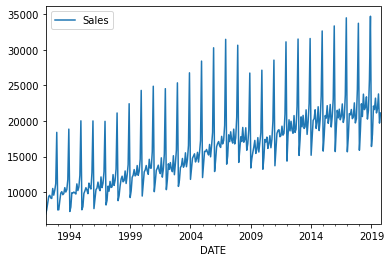

In [41]:
#Exploratory Analysis
df.plot()
#Monthly sales data
#periodicity and seasonality in data
#A general increasing trend of sales with kink around 2008

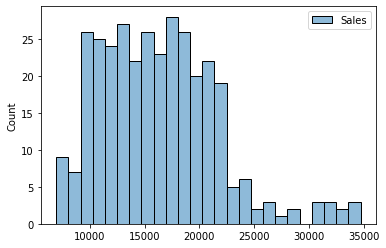

In [42]:
sns.histplot(df, bins=25)
#Median Sales
#Right skewed distribution

In [43]:

test_ind=18;#one and a half year dataset or 18 months
len(df)-test_ind

316

In [44]:
#test train split for testing
train_data=df[:-test_ind]
test_data=df[-test_ind:]
len(train_data)

316

In [45]:
#Data Preparation
#Scaling Data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train_data);
scaled_train_data = scaler.transform(train_data);
scaled_test_data = scaler.transform(test_data)

#Sequence Generator
seq_length=12;#From time series plot of sales above as the periodicity suggests
#import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_generator=TimeseriesGenerator(scaled_train_data,scaled_train_data,length=seq_length,batch_size=1)
validation_generator=TimeseriesGenerator(scaled_test_data,scaled_test_data,length=seq_length,batch_size=1)

In [46]:

#Model Building
n_features=1;#only one feature to predict in the sequence
hidden_state=100;# LSTM hidden states
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
model=Sequential();
model.add(LSTM(hidden_state,activation='relu',input_shape=(seq_length,n_features)));
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [47]:

#Early Stopping for regularization to prevent over and underfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',patience=2)

In [48]:
#Model Fitting 
model.fit(train_generator,epochs=20,validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 4s 8ms/step - loss: 0.0249 - val_loss: 0.0069
Epoch 2/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0178 - val_loss: 0.0022
Epoch 3/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0103 - val_loss: 0.0021
Epoch 4/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0048 - val_loss: 0.0160
Epoch 5/20
304/304 [==============================] - 4s 12ms/step - loss: 0.0051 - val_loss: 5.9322e-04
Epoch 6/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0018 - val_loss: 3.0007e-04
Epoch 7/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 8/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0013 - val_loss: 2.8709e-04
Epoch 9/20
304/304 [==============================] - 2s 8ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 10/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0015 - val

In [49]:

#Loss plot
losses=pd.DataFrame(model.history.history)
losses.columns

Index(['loss', 'val_loss'], dtype='object')

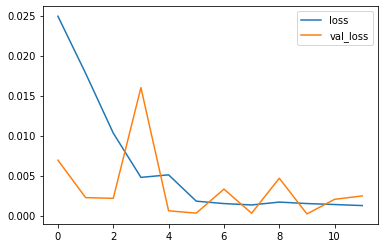

In [50]:
losses.plot()

In [51]:
#Data Prediction
test_pred=[]#to store predictions
first_batch= scaled_train_data[-seq_length:];
current_batch = first_batch.reshape((1,seq_length,n_features))
for i in range(test_ind):
    current_pred = model.predict(current_batch);
    test_pred.append(current_pred[0])
    current_batch=np.append(current_batch[:,1:,:],[[current_pred[0]]],axis=1)
#Data Predictions
predictions=scaler.inverse_transform(test_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


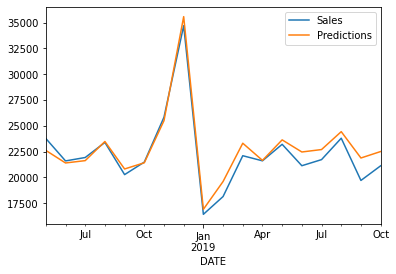

In [52]:
test_data['Predictions']=predictions;
test_data.plot()
#Sales Predictions remain a bit erroneous over the actual

In [70]:
#RMSE
mse=(1/len(test_data))*np.sum((test_data['Sales']-test_data['Predictions'])**2)
RMSE=np.sqrt(mse)
print('RMSE for predictions=',RMSE,'units \nRange of sales data between 6938 and 34706 units min and max sales')
print('Percentage RMSE error with respect to minimum sales\n:',100*RMSE/6938,'%')
#Error seems more or less tolerable under 15 % limit

RMSE for predictions= 956.1928168743965 units 
Range of sales data between 6938 and 34706 units min and max sales
Percentage RMSE error with respect to minimum sales
: 13.78196622765057 %


# Forecasting Sales

In [54]:
#Sales Forecast
fperiod = 12;
#Scaling and Normalization 
full_scaler=MinMaxScaler()
full_scaler.fit(df)
scaled_df=full_scaler.transform(df)
#forecast sequence generator using full data
fgenerator=TimeseriesGenerator(scaled_df,scaled_df,seq_length,batch_size=1)
#Forecast Model Build
hidden_state=100;
fmodel=Sequential()
fmodel.add(LSTM(hidden_state,activation='relu',input_shape=(seq_length,n_features)))
fmodel.add(Dense(1))
fmodel.compile(optimizer='adam',loss='mse')
fmodel.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [55]:
fmodel.fit_generator(fgenerator,epochs=8)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


322/322 [==============================] - 4s 8ms/step - loss: 0.0269
Epoch 2/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0172
Epoch 3/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0100
Epoch 4/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0044
Epoch 5/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0027
Epoch 6/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0022
Epoch 7/8
322/322 [==============================] - 2s 7ms/step - loss: 0.0018
Epoch 8/8
322/322 [==============================] - 3s 8ms/step - loss: 0.0014


In [56]:
#Data Prediction
test_pred=[]#to store predictions
first_batch= scaled_df[-seq_length:];
current_batch = first_batch.reshape((1,seq_length,n_features))
for i in range(fperiod):#iteration over forecast period
    current_pred = model.predict(current_batch);
    test_pred.append(current_pred[0])
    current_batch=np.append(current_batch[:,1:,:],[[current_pred[0]]],axis=1)
#Data Predictions
forecast=scaler.inverse_transform(test_pred)

In [57]:
forecast.transpose()

array([[26787.04886484, 36463.76668072, 17168.54094887, 19136.95855761,
        22893.642869  , 22490.21884251, 24095.01666164, 22137.30326509,
        22736.74243116, 24644.91436958, 20920.95835114, 22219.41376638]])

In [58]:
df[-1:]
#Date of last update required for forecast period index

,Sales
DATE,
2019-10-01,21113


In [59]:
forecast_period=pd.date_range(start='2019-11-01',periods=fperiod,freq='MS')
forecast_period

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

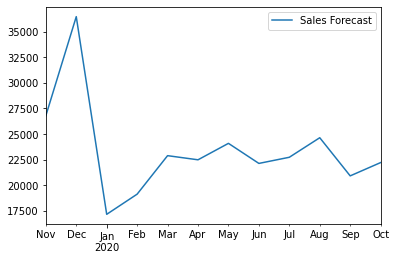

In [60]:
forecast_df=pd.DataFrame(data=forecast,index=forecast_period,columns=['Sales Forecast'])
forecast_df.plot()

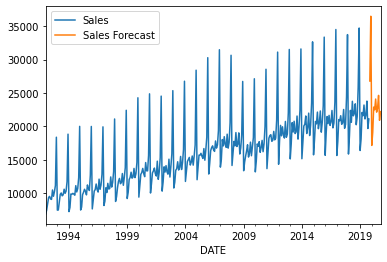

In [61]:
ax=df.plot()
forecast_df.plot(ax=ax)
#probable general trend identification thus, taking the 2008 kink into account